# CNN モデルの発展
前回学んだ CNN の基礎を元に発展してきた代表的なモデルについて学習する.  
まずは必要なライブラリをインポートする.

In [1]:
# 必要なライブラリのインポート
import warnings

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

共通で使う関数を定義する.

In [2]:
def plot_data(train_loss_list: list, test_loss_list: list) -> None:
    """
    学習過程の損失をプロットする関数

    Parameters
    ----------
    train_loss_list: list
        学習用データにおける学習過程の損失を格納したリスト
    test_loss_list: list
        テスト用データにおける学習過程の損失を格納したリスト

    Returns
    ----------
    None
    """
    # 横軸の設定
    x = [i + 1 for i in range(len(train_loss_list))]

    # 出力画像の設定
    plt.figure(figsize=(18, 12), tight_layout=True)
    plt.title("Training Loss over Epochs", size=15, color="red")
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # 学習過程の損失をプロット
    plt.plot(x, train_loss_list, label="Train Loss", color="blue")
    plt.plot(x, test_loss_list, label="Test Loss", color="orange")

    # グラフの表示
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0)
    plt.show()


def train(
    model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer,
    data_loaders: dict, num_epochs: int
) -> tuple[nn.Module, list, list]:
    """
    モデルの学習を行う関数

    Parameters
    ----------
    model: nn.Module
        学習するモデル
    criterion: nn.Module
        損失関数
    optimizer: optim.Optimizer
        最適化手法
    data_loaders: dict
        学習用・テスト用データの DataLoader を格納した辞書
    num_epochs: int
        学習のエポック数

    Returns
    ----------
    model: nn.Module
        学習後のモデル
    train_loss_list: list
        学習用データにおける学習過程の損失を格納したリスト
    test_loss_list: list
        テスト用データにおける学習過程の損失を格納したリスト
    """
    # 学習用・テスト用データの損失を格納するリスト
    train_loss_list = []
    test_loss_list = []

    # 学習ループの実行
    with tqdm(range(num_epochs)) as pbar_epoch:
        # エポックごとのループ
        for epoch in pbar_epoch:
            # エポック数の表示
            pbar_epoch.set_description(f"Epoch {epoch + 1}")

            # フェーズごとのループ
            for phase in ["train", "test"]:
                # フェーズに応じてモデルのモードを切り替え
                if phase == "train":
                    # モデルを学習モードに設定
                    model.train()
                else:
                    # モデルを評価モードに設定
                    model.eval()

                # エポックの損失を初期化
                epoch_loss = 0.0

                # ミニバッチ学習の実行
                for inputs, labels in data_loaders[phase]:
                    # 勾配の初期化
                    optimizer.zero_grad()

                    # 順伝播の計算
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        # 学習モードのときのみ逆伝播の計算とパラメータの更新
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # エポックの損失を更新
                    epoch_loss += loss.item() * inputs.size(0)

                # エポックの平均損失を計算
                epoch_loss /= len(data_loaders[phase].dataset)
                if phase == "train":
                    train_loss_list.append(epoch_loss)
                else:
                    test_loss_list.append(epoch_loss)

    return model, train_loss_list, test_loss_list

ノートブックで使用する諸々の設定を先に行う.

In [3]:
# 警告メッセージを非表示にする
warnings.filterwarnings("ignore")

# 乱数シードの設定
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

続いて, FashionMNSIT というデータセットを使う.

学習用データセットの要素数: 60000
テスト用データセットの要素数: 10000
画像のサイズ: (28, 28)
ラベル: 9


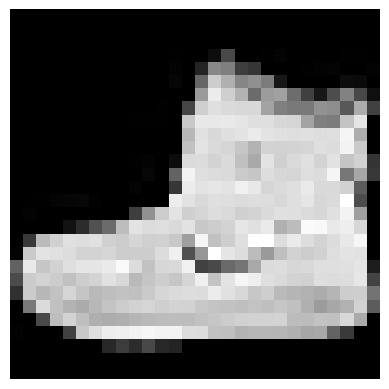

In [4]:
# データを保存するディレクトリ
data_dir = "./data"

# 学習用・テスト用データセット
train_dataset = datasets.FashionMNIST(
    root=data_dir, train=True,
    download=True, transform=None
)
test_dataset = datasets.FashionMNIST(
    root=data_dir, train=False,
    download=True, transform=None
)

# データセットの要素数を表示
print(f"学習用データセットの要素数: {len(train_dataset)}")
print(f"テスト用データセットの要素数: {len(test_dataset)}")

# データセットの最初の要素を表示
image, label = train_dataset[0]
print(f"画像のサイズ: {image.size}")
print(f"ラベル: {label}")

# 画像を表示
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

前回の MNSIT データセット同様に前処理を先に行っておく.

In [5]:
# 前処理の定義
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# 前処理を適用した学習用・テスト用データセット
train_dataset = datasets.FashionMNIST(
    root=data_dir, train=True,
    download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root=data_dir, train=False,
    download=True, transform=transform
)

# DataLoader の作成
batch_size = 256
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

# DataLoader の辞書
data_loaders = {"train": train_loader, "test": test_loader}

# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# エポック数の設定
num_epochs = 300

# テストデータの正解ラベルを取得
y_test = torch.cat([y for _, y in test_loader], dim=0)

## LeNet
**LeNet** は, 1989年に Yann LeCun らによって原型が提案され, 1998年に当時の最先端モデルとして脚光を浴びた.  
基本的な CNN の流れ(畳み込み層, プーリング層, 全結合層)を確立した.  
以下に PyTorch での実装を行う.

In [6]:
class LeNetEncoder(nn.Module):
    def __init__(self):
        # 親クラスのコンストラクタを呼び出す
        super(LeNetEncoder, self).__init__()

        # 畳み込み層の定義
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)

        # プーリング層の定義
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 活性化関数の定義
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # 順伝播の計算
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        return x


class LeNetDecoder(nn.Module):
    def __init__(self, num_classes: int = 10):
        # 親クラスのコンストラクタを呼び出す
        super(LeNetDecoder, self).__init__()

        # 全結合層の定義
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # 活性化関数の定義
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # テンソルの形状を変換
        x = x.view(-1, 16 * 4 * 4)

        # 順伝播の計算
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class LeNet(nn.Module):
    def __init__(self, num_classes: int = 10):
        # 親クラスのコンストラクタを呼び出す
        super(LeNet, self).__init__()

        # エンコーダとデコーダの定義
        self.encoder = LeNetEncoder()
        self.decoder = LeNetDecoder(num_classes=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # 順伝播の計算
        x = self.encoder(x)
        x = self.decoder(x)

        return x

モデルのインスタンスを作成し, ネットワークのアーキテクチャを確認する.

In [7]:
# モデルのインスタンスを作成
lenet = LeNet(num_classes=10)
print(lenet)

LeNet(
  (encoder): LeNetEncoder(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (decoder): LeNetDecoder(
    (fc1): Linear(in_features=256, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
    (relu): ReLU()
  )
)


FashionMNIST データを学習する.

Epoch 300: 100%|██████████| 300/300 [29:08<00:00,  5.83s/it]


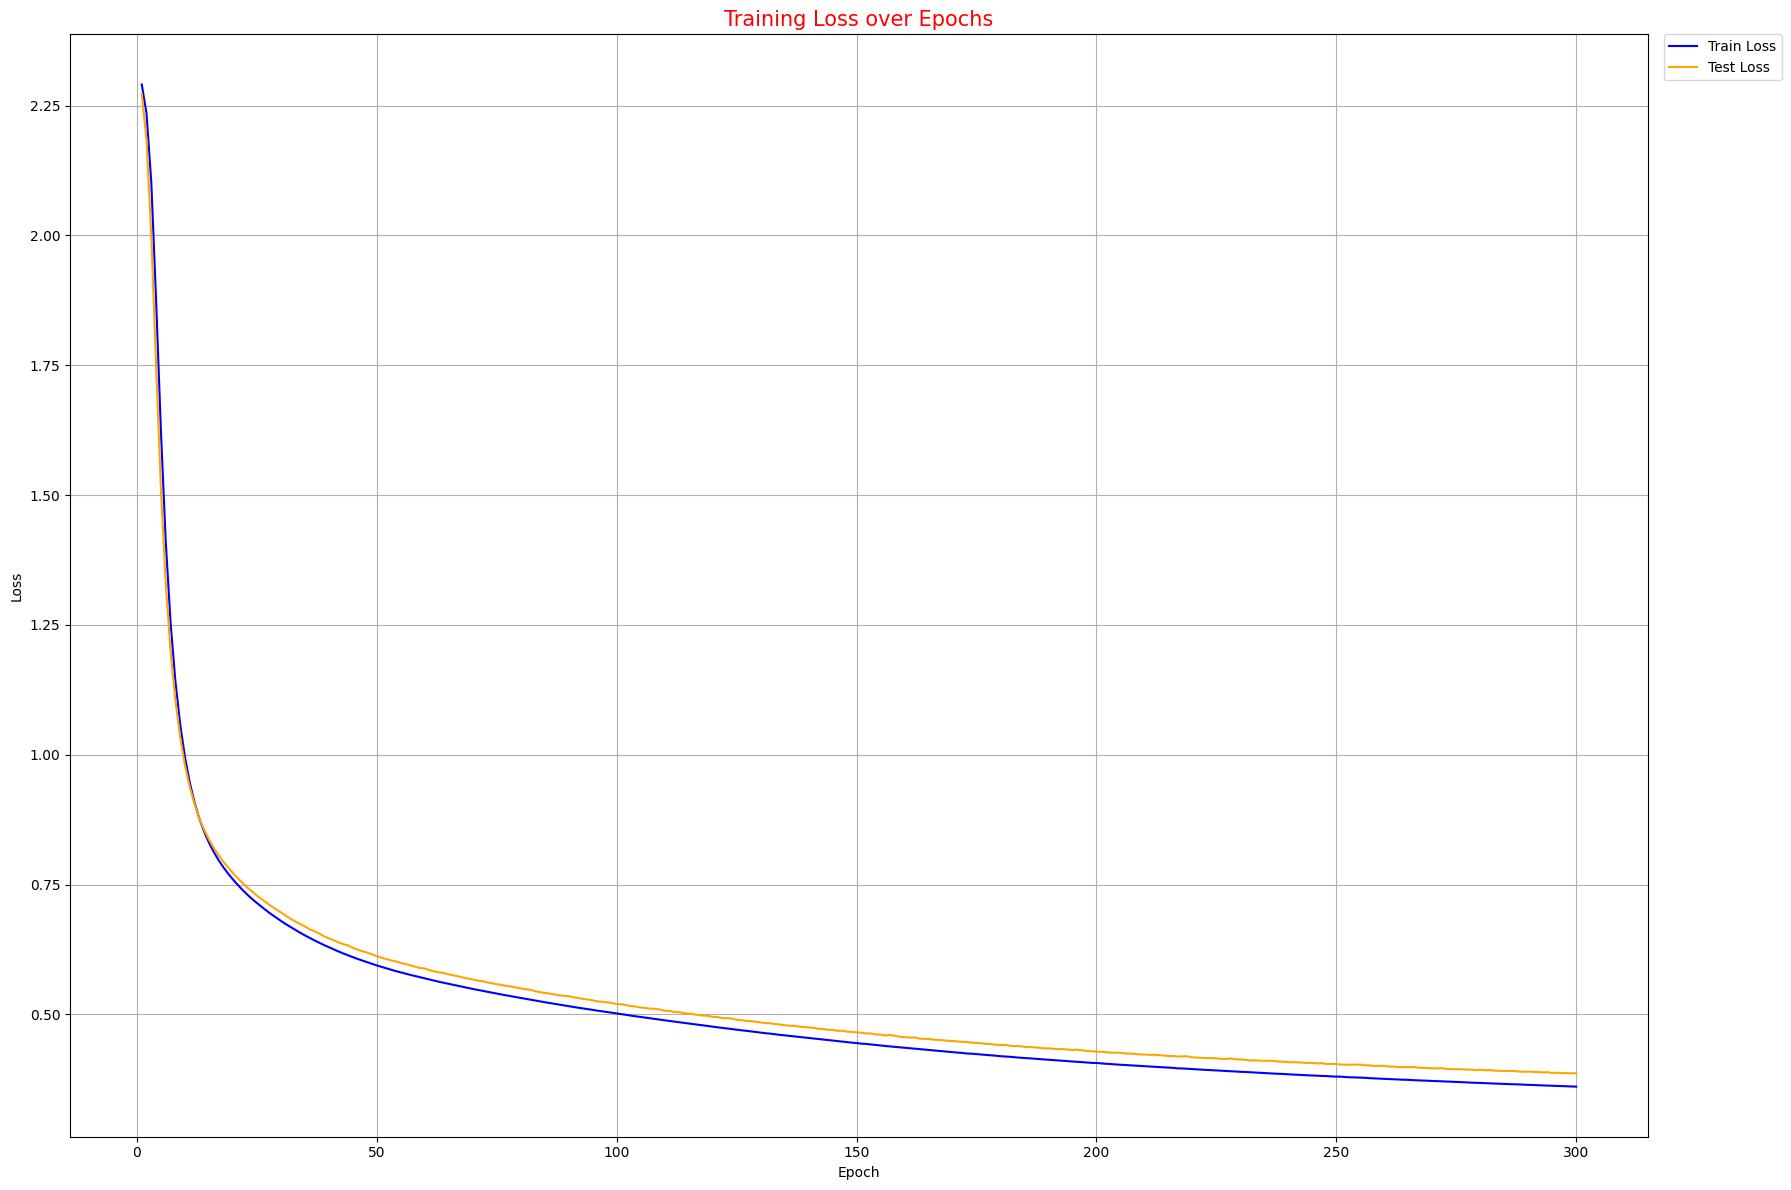

In [8]:
# 最適化手法の設定
optimizer = optim.Adam(lenet.parameters(), lr=0.00001)

# 学習の実行
lenet, train_loss_list, test_loss_list = train(
    lenet, criterion, optimizer, data_loaders, num_epochs
)

# 学習過程の損失をプロット
plot_data(train_loss_list, test_loss_list)

収束が確認できたので, LeNet でテストデータの精度を検証してみる.

In [9]:
# テストデータに対する予測を実行
lenet.eval()
y_preds_lenet = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = lenet(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds_lenet.extend(preds.cpu().numpy())

# 予測と正解の評価指標を表示
print(classification_report(y_test.numpy(), y_preds_lenet))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1000
           1       0.98      0.97      0.97      1000
           2       0.77      0.80      0.78      1000
           3       0.87      0.86      0.87      1000
           4       0.76      0.79      0.78      1000
           5       0.96      0.95      0.95      1000
           6       0.65      0.56      0.60      1000
           7       0.92      0.95      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



FashionMNIST も難しいデータセットでは無いので, LeNet でも高精度で予測できていることがわかる.

## AlexNet
**AlexNet** は, 2012年に開催された [ILSVRC 2012](https://www.image-net.org/challenges/LSVRC/2012/) にて, エラー率が 15.3% で準優勝したモデルよりも 10% 以上差をつけて圧倒的な優勝を飾ったモデルである.  
深層学習の再ブームの火付け役にもなったことでよく知られている.  
畳み込みが5層と線形の全結合層が3層のアーキテクチャを持っており, GPU を使ったニューラルネットワークの学習の定番化がなされた.  
また, **ドロップアウト** という一部のパラメータを学習させない手法を提案した.  
以下に PyTorch での実装を行う.

In [10]:
class AlexNetEncoder(nn.Module):
    def __init__(self):
        # 親クラスのコンストラクタを呼び出す
        super(AlexNetEncoder, self).__init__()

        # 畳み込み層の定義
        self.conv1 = nn.Conv2d(1, 32, kernel_size=11, stride=1, padding=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)

        # プーリング層の定義
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        # 活性化関数の定義
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # 順伝播の計算
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))

        x = self.relu(self.conv4(x))

        x = self.relu(self.conv5(x))
        x = self.pool(x)

        return x


class AlexNetDecoder(nn.Module):
    def __init__(self, num_classes: int = 10):
        # 親クラスのコンストラクタを呼び出す
        super(AlexNetDecoder, self).__init__()

        # 全結合層の定義
        self.fc1 = nn.Linear(64 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, num_classes)

        # 活性化関数の定義
        self.relu = nn.ReLU()

        # ドロップアウトの定義
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # テンソルの形状を変換
        x = x.view(-1, 64 * 2 * 2)

        # 順伝播の計算
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 10):
        # 親クラスのコンストラクタを呼び出す
        super(AlexNet, self).__init__()

        # エンコーダとデコーダの定義
        self.encoder = AlexNetEncoder()
        self.decoder = AlexNetDecoder(num_classes=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # 順伝播の計算
        x = self.encoder(x)
        x = self.decoder(x)

        return x

モデルのインスタンスを作成し, ネットワークのアーキテクチャを確認する.

In [11]:
# モデルのインスタンスを作成
alexnet = AlexNet(num_classes=10)
print(alexnet)

AlexNet(
  (encoder): AlexNetEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (decoder): AlexNetDecoder(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=10, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


FashionMNIST データを学習する.

Epoch 300: 100%|██████████| 300/300 [4:05:07<00:00, 49.03s/it]  


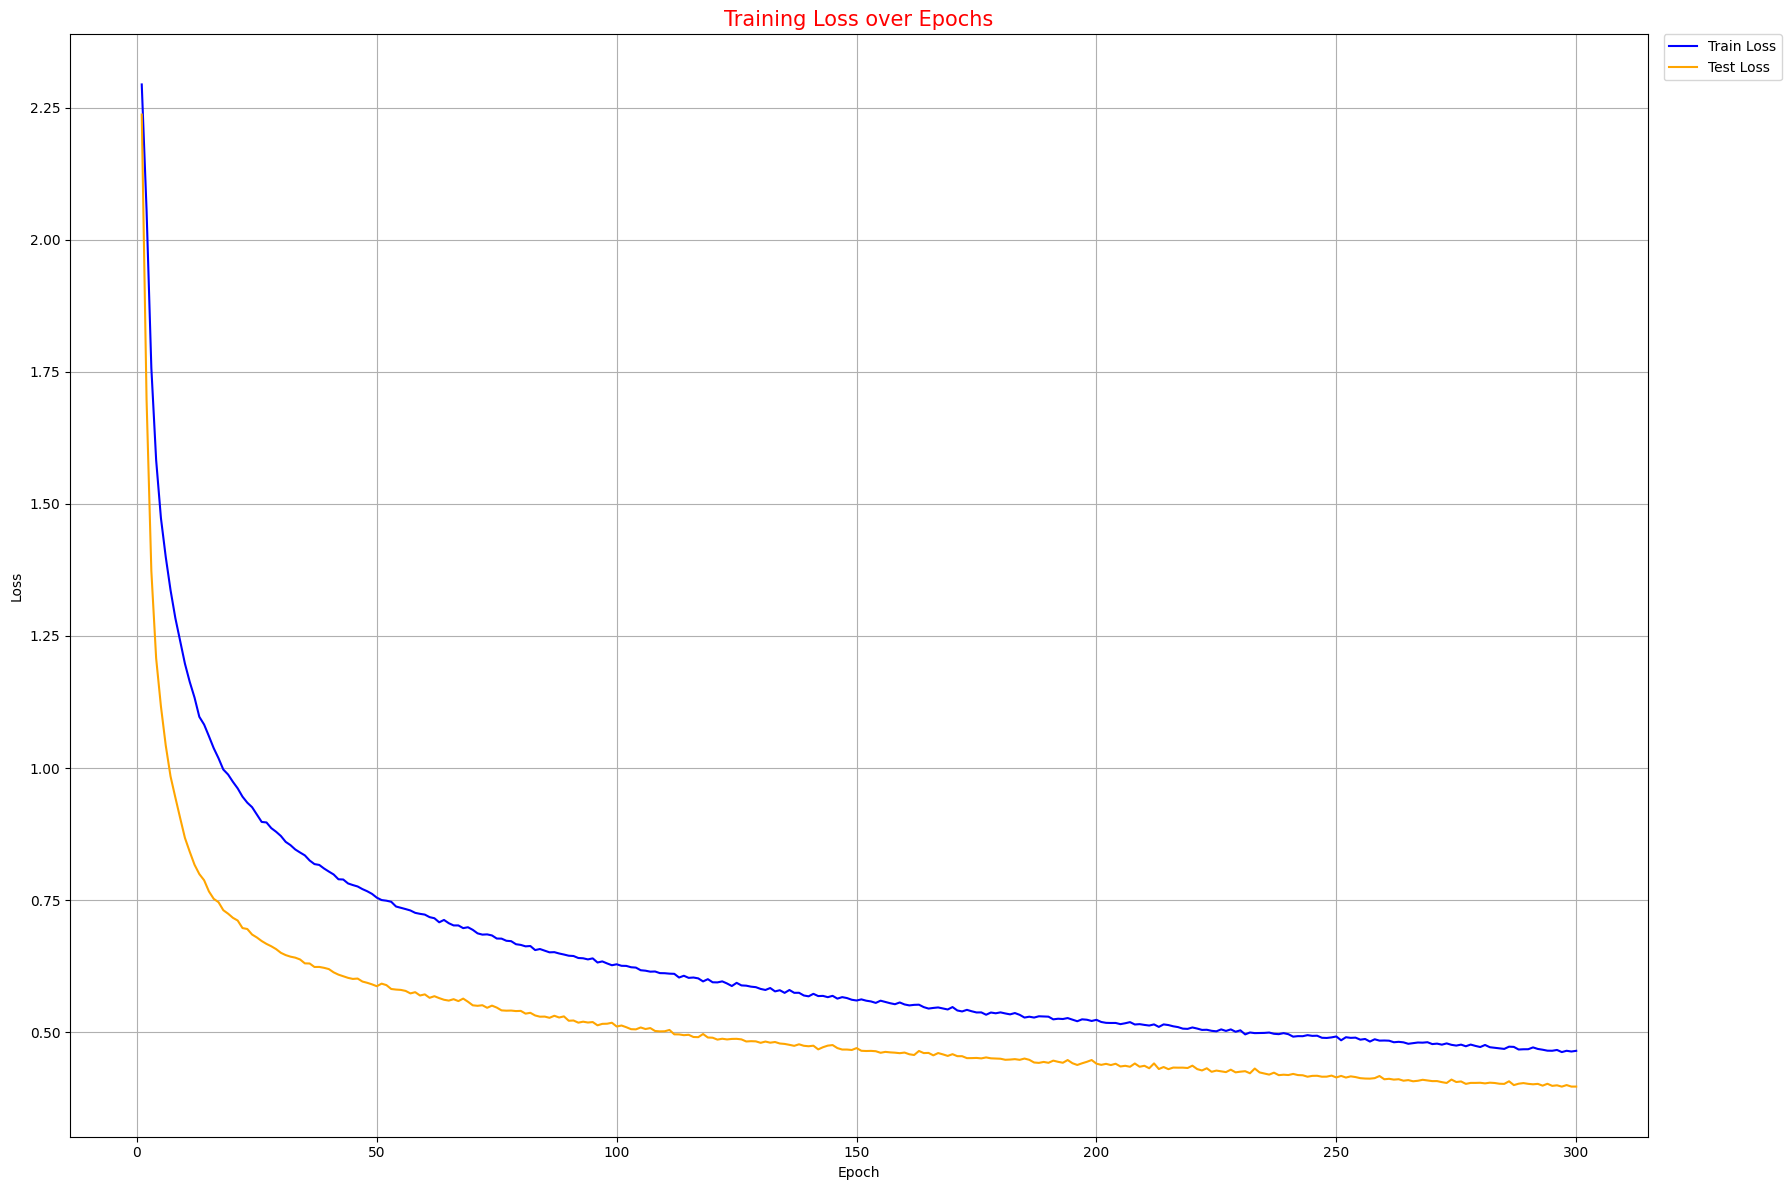

In [12]:
# 最適化手法の設定
optimizer = optim.Adam(alexnet.parameters(), lr=0.00001)

# 学習の実行
alexnet, train_loss_list, test_loss_list = train(
    alexnet, criterion, optimizer, data_loaders, num_epochs
)

# 学習過程の損失をプロット
plot_data(train_loss_list, test_loss_list)

収束には向かったが, このグラフを見ると恒常的にテスト用データでのロスが学習用データでのロスを下回っている.  
普通は学習したデータより精度高く予測するということは出来ないはずなので, データに対してモデルが過剰な表現力を持ってしまっていることがわかる.  
念の為, テストデータセットに対して評価を行う.

In [13]:
# テストデータに対する予測を実行
alexnet.eval()
y_preds_alexnet = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = alexnet(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds_alexnet.extend(preds.cpu().numpy())

# 予測と正解の評価指標を表示
print(classification_report(y_test.numpy(), y_preds_alexnet))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      1000
           1       0.99      0.96      0.98      1000
           2       0.74      0.72      0.73      1000
           3       0.89      0.88      0.89      1000
           4       0.72      0.81      0.76      1000
           5       0.96      0.98      0.97      1000
           6       0.61      0.42      0.49      1000
           7       0.96      0.94      0.95      1000
           8       0.96      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



やはり LeNet と比べて同程度かそれ以下の制度となってしまっている.  
学習時間の差もあり, このモデルは FashionMNIST のデータセットで分類を行うには少しばかり高級であると考えられる.

## VGG
**VGG** は, 2014年に登場した $3 \times 3$ の小さいウィンドウを積み重ねるだけのシンプルなモデルである.  
計算コストが大きいものの, 構造が複雑で無い分理解しやすく, 後続の研究に大きな影響を与えた.  
以下に PyTorch での実装を行う.

In [14]:
class VGGEncoder(nn.Module):
    def __init__(self):
        # 親クラスのコンストラクタを呼び出す
        super(VGGEncoder, self).__init__()

        # 畳み込み層の1層目を定義
        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)

        # 畳み込み層の2層目を定義
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

        # 畳み込み層の3層目を定義
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # 畳み込み層の4層目を定義
        self.conv4_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        # プーリング層の定義
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 活性化関数の定義
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # 1層目の順伝播の計算
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool(x)

        # 2層目の順伝播の計算
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.pool(x)

        # 3層目の順伝播の計算
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        x = self.pool(x)

        # 4層目の順伝播の計算
        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        x = self.pool(x)

        return x


class VGGDecoder(nn.Module):
    def __init__(self, num_classes: int = 10):
        # 親クラスのコンストラクタを呼び出す
        super(VGGDecoder, self).__init__()

        # 全結合層の定義
        self.fc1 = nn.Linear(128 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

        # 活性化関数の定義
        self.relu = nn.ReLU()

        # ドロップアウトの定義
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # テンソルの形状を変換
        x = x.view(-1, 128 * 1 * 1)

        # 順伝播の計算
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x


class VGG(nn.Module):
    def __init__(self, num_classes: int = 10):
        # 親クラスのコンストラクタを呼び出す
        super(VGG, self).__init__()

        # エンコーダとデコーダの定義
        self.encoder = VGGEncoder()
        self.decoder = VGGDecoder(num_classes=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # 順伝播の計算
        x = self.encoder(x)
        x = self.decoder(x)

        return x

モデルのインスタンスを作成し, ネットワークのアーキテクチャを確認する.

In [15]:
# モデルのインスタンスを作成
vgg = VGG(num_classes=10)
print(vgg)

VGG(
  (encoder): VGGEncoder(
    (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (decoder): VGGDecoder(
    (fc1): Linear(in_

FashionMNIST データを学習する.

Epoch 300: 100%|██████████| 300/300 [4:20:32<00:00, 52.11s/it]  


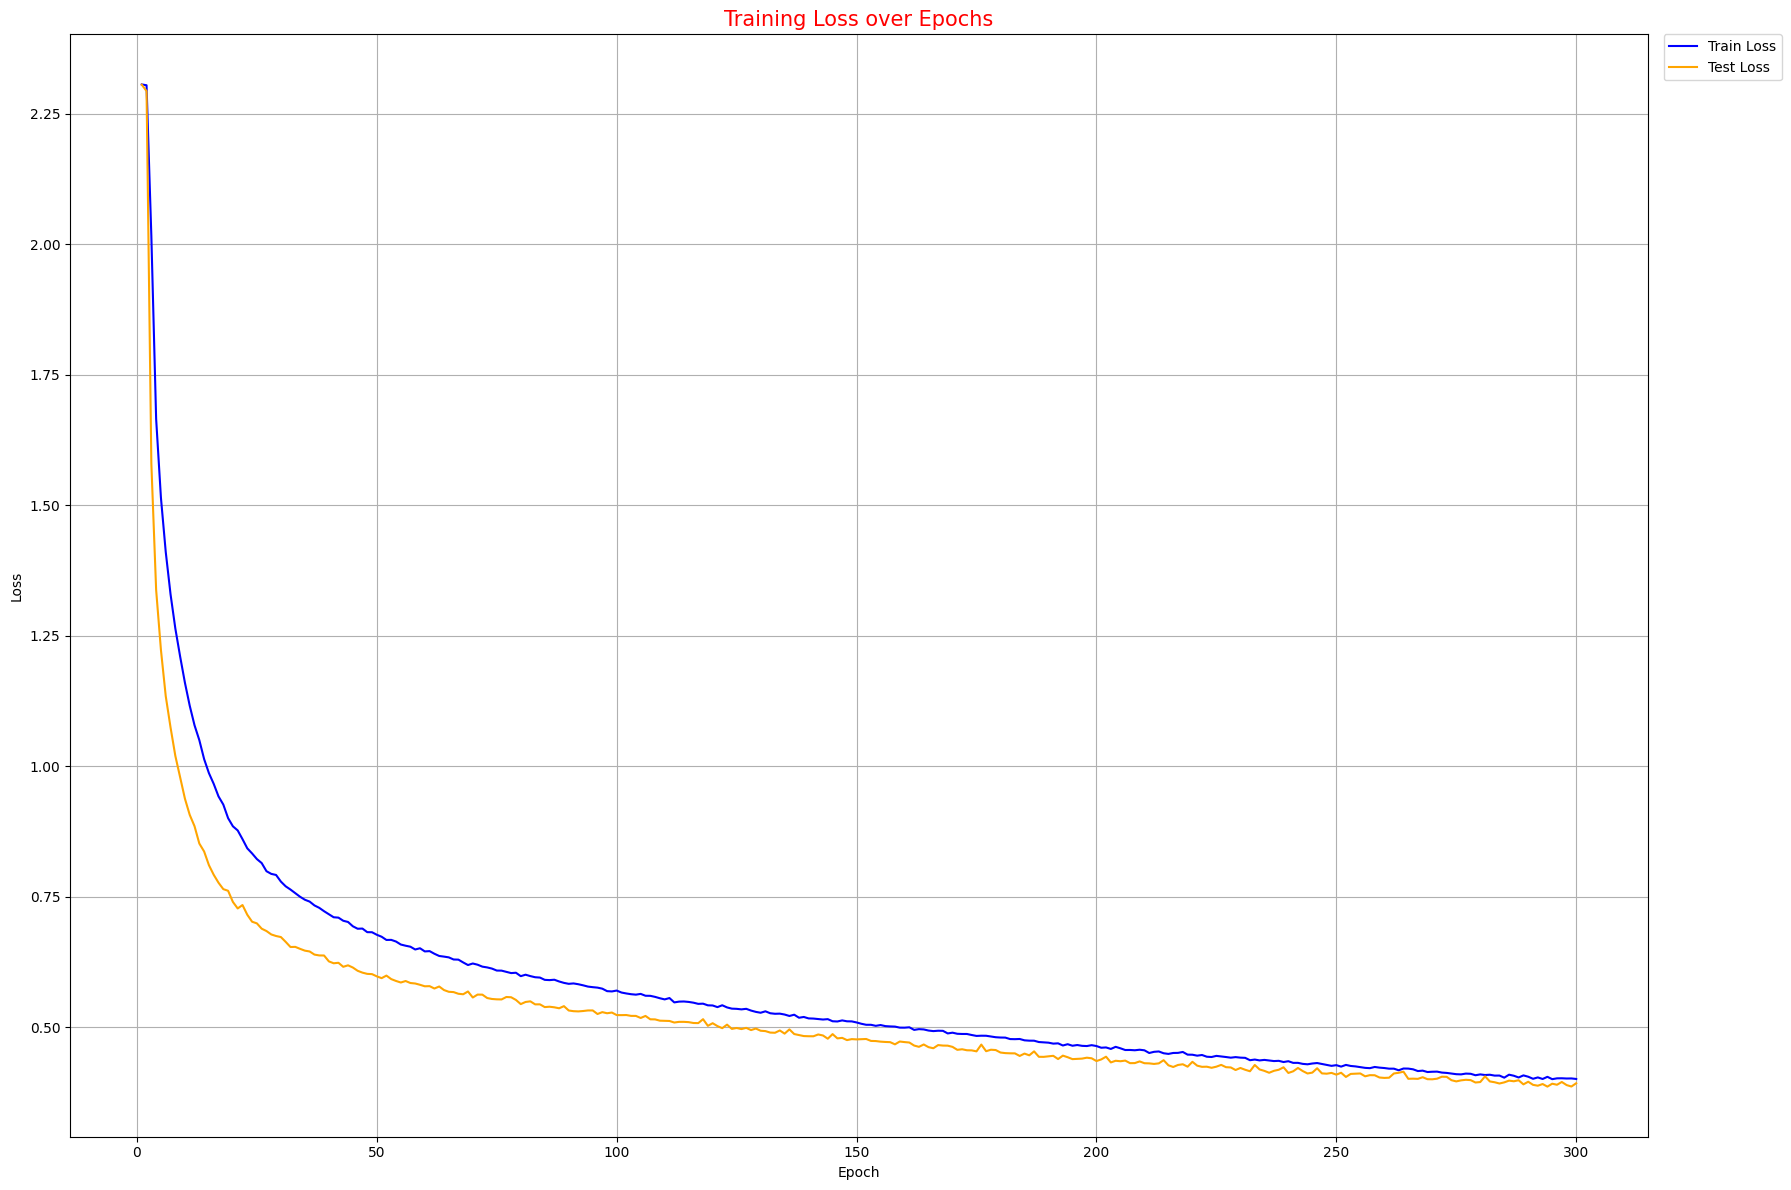

In [16]:
# 最適化手法の設定
optimizer = optim.Adam(vgg.parameters(), lr=0.00001)

# 学習の実行
vgg, train_loss_list, test_loss_list = train(
    vgg, criterion, optimizer, data_loaders, num_epochs
)

# 学習過程の損失をプロット
plot_data(train_loss_list, test_loss_list)

AlexNet と同様に, このグラフからは恒常的に学習用データでのロスがテスト用データでのロスを上回っている.  
一方で, 300エポック時点ではまだ収束出来ていないようにも思えるし, 両者の差は AlexNet の時よりも小さいため, もうしばらくエポックを重ねるとロスが逆転しながら収束に向かう可能性がある.  
一旦現時点での評価を確認する.

In [17]:
# テストデータに対する予測を実行
vgg.eval()
y_preds_vgg = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = vgg(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds_vgg.extend(preds.cpu().numpy())

# 予測と正解の評価指標を表示
print(classification_report(y_test.numpy(), y_preds_vgg))

              precision    recall  f1-score   support

           0       0.73      0.83      0.78      1000
           1       0.99      0.96      0.97      1000
           2       0.80      0.75      0.77      1000
           3       0.80      0.90      0.85      1000
           4       0.74      0.78      0.76      1000
           5       0.96      0.94      0.95      1000
           6       0.61      0.45      0.52      1000
           7       0.89      0.97      0.93      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.92      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



やはり他のモデルと同程度, もしくはそれより低いくらいの精度であった.  
VGG もアーキテクチャ内の層が非常に深くなっているため, データ量に対してモデルが高級であると言える.

## ResNet
**ResNet** は, 2015年に「深すぎるネットワークでは勾配消失が発生する」という問題を解決するために, **残差ブロック** を導入したモデルである.  
これにより, 非常に深いネットワークでの学習を安定化させられるようになった.  
以下に PyTorch での実装を行う.

In [18]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        # 親クラスのコンストラクタを呼び出す
        super(ResNetBlock, self).__init__()

        # 畳み込み層の定義
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1
        )

        # バッチ正規化層の定義
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 活性化関数の定義
        self.relu = nn.ReLU()

        # スキップ接続のための層を定義
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, padding=0
                ),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # スキップ接続の計算
        identity = self.shortcut(x)

        # 順伝播の計算
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # スキップ接続の結果を加算
        out += identity
        out = self.relu(out)

        return out


class ResNetEncoder(nn.Module):
    def __init__(self):
        # 親クラスのコンストラクタを呼び出す
        super(ResNetEncoder, self).__init__()

        # 畳み込み層の定義
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)

        # バッチ正規化層の定義
        self.bn1 = nn.BatchNorm2d(16)

        # 各層の ResNet ブロックを定義
        self.layer1 = self.make_layer(16, 16, num_blocks=2, stride=1)
        self.layer2 = self.make_layer(16, 32, num_blocks=2, stride=2)
        self.layer3 = self.make_layer(32, 64, num_blocks=2, stride=2)
        self.layer4 = self.make_layer(64, 128, num_blocks=2, stride=2)

        # プーリング層の定義
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # 活性化関数の定義
        self.relu = nn.ReLU()
    
    def make_layer(
        self, in_channels: int, out_channels: int,
        num_blocks: int, stride: int
    ) -> nn.Sequential:
        """
        ResNet ブロックを複数積み重ねた層を作成する関数

        Parameters
        ----------
        in_channels: int
            入力チャネル数
        out_channels: int
            出力チャネル数
        num_blocks: int
            ResNet ブロックの数
        stride: int
            畳み込みのストライド

        Returns
        ----------
        layers: nn.Sequential
            ResNet ブロックを複数積み重ねた層
        """
        # ResNet ブロックを格納するリスト
        layers = []

        # 最初の ResNet ブロックを追加
        layers.append(ResNetBlock(in_channels, out_channels, stride))

        # 残りの ResNet ブロックを追加
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels, stride=1))

        # Sequential オブジェクトを作成して返す
        layers = nn.Sequential(*layers)

        return layers
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # 順伝播の計算
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)

        return x


class ResNetDecoder(nn.Module):
    def __init__(self, num_classes: int = 10):
        # 親クラスのコンストラクタを呼び出す
        super(ResNetDecoder, self).__init__()

        # 全結合層の定義
        self.fc1 = nn.Linear(128 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

        # 活性化関数の定義
        self.relu = nn.ReLU()

        # ドロップアウトの定義
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # テンソルの形状を変換
        x = x.view(-1, 128 * 1 * 1)

        # 順伝播の計算
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x


class ResNet(nn.Module):
    def __init__(self, num_classes: int = 10):
        # 親クラスのコンストラクタを呼び出す
        super(ResNet, self).__init__()

        # エンコーダとデコーダの定義
        self.encoder = ResNetEncoder()
        self.decoder = ResNetDecoder(num_classes=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行う関数

        Parameters
        ----------
        x: torch.Tensor
            入力データ

        Returns
        ----------
        x: torch.Tensor
            入力データに対する予測結果
        """
        # 順伝播の計算
        x = self.encoder(x)
        x = self.decoder(x)

        return x

モデルのインスタンスを作成し, ネットワークのアーキテクチャを確認する.

In [19]:
# モデルのインスタンスを作成
resnet = ResNet(num_classes=10)
print(resnet)

ResNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): ResNetBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (shortcut): Identity()
      )
      (1): ResNetBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(16, eps=1e-05, 

FashionMNIST データを学習する.

Epoch 300: 100%|██████████| 300/300 [11:21:52<00:00, 136.37s/it]  


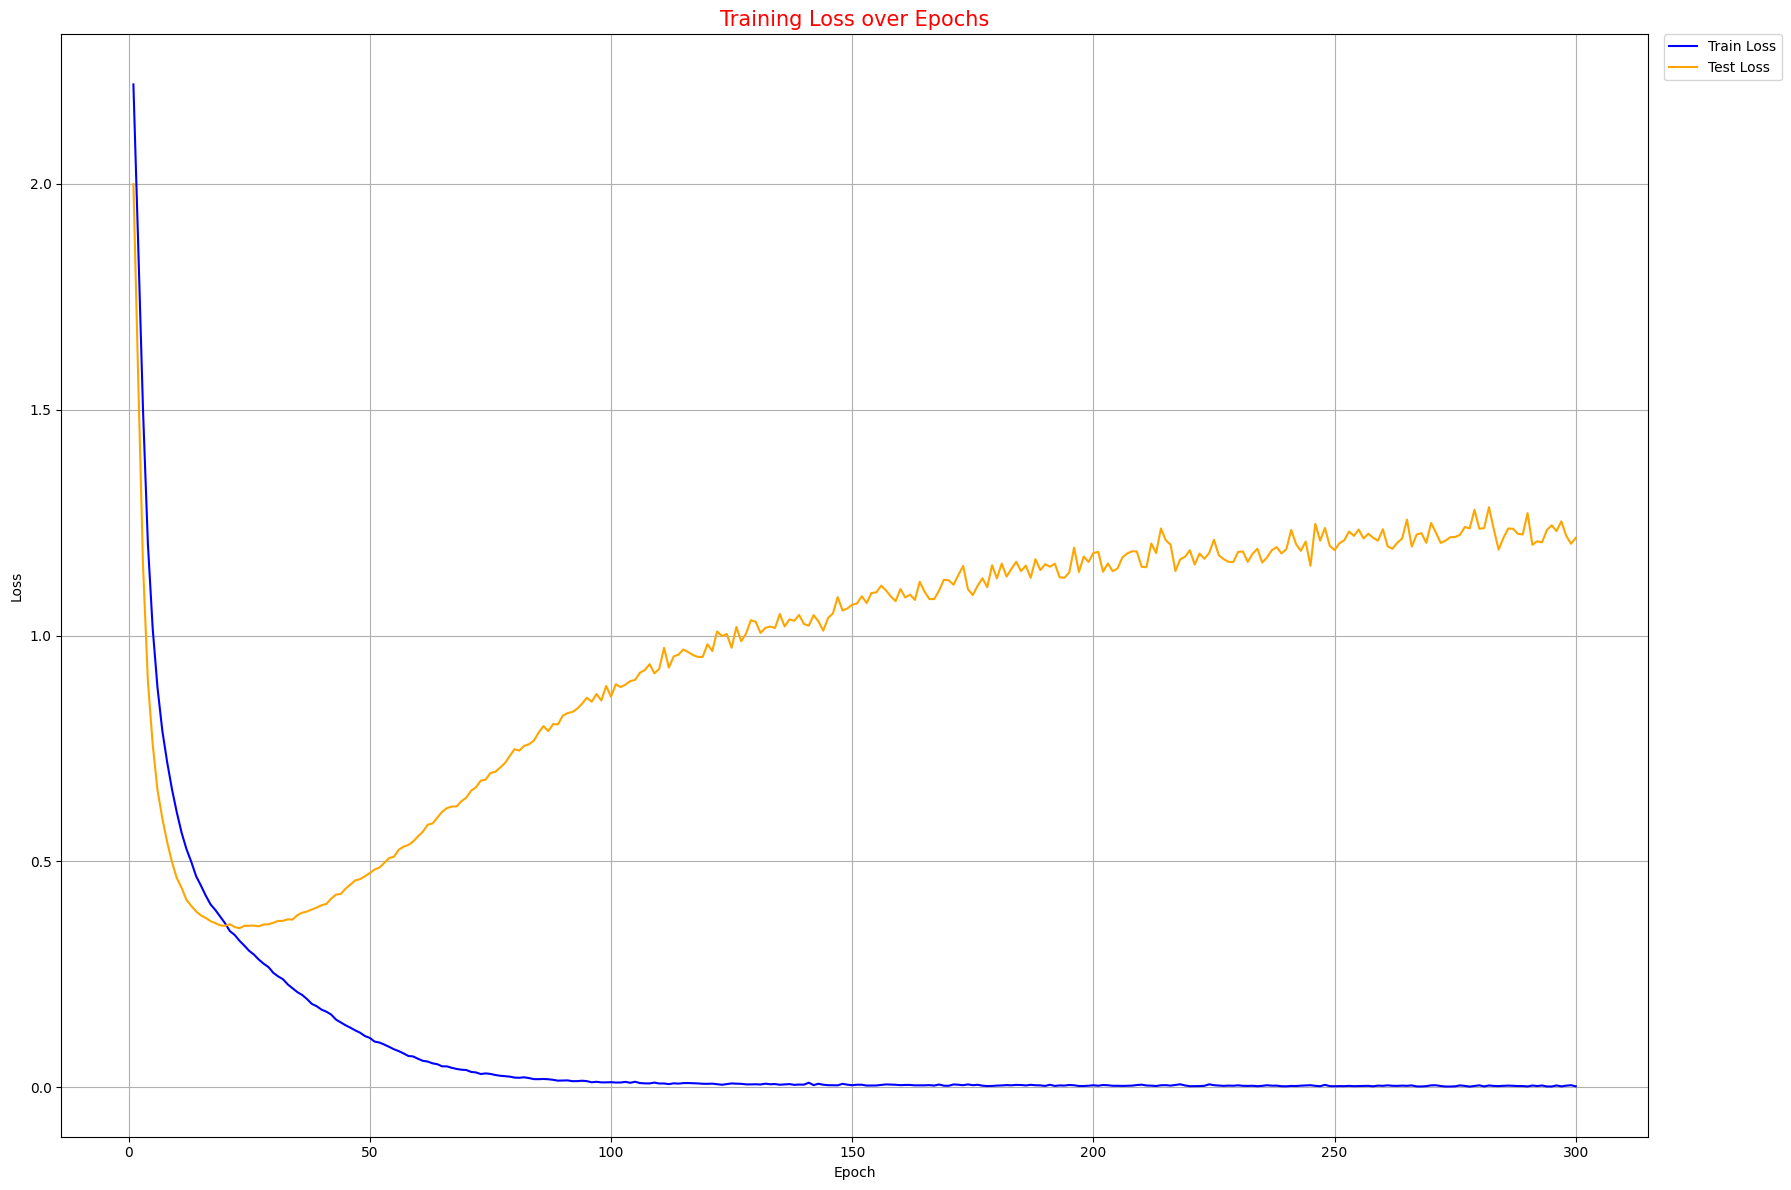

In [20]:
# 最適化手法の設定
optimizer = optim.Adam(resnet.parameters(), lr=0.00001)

# 学習の実行
resnet, train_loss_list, test_loss_list = train(
    resnet, criterion, optimizer, data_loaders, num_epochs
)

# 学習過程の損失をプロット
plot_data(train_loss_list, test_loss_list)

25エポック頃からテストデータのロスが大きくなって学習データのロスト差が開いており, 過学習が確認できる.  
ResNet では, 学習率を大幅に下げるか, エポック数を50未満で設定しないと FashionMNIST データセットでの汎化性能は難しいことが分かった.  
ちなみに評価を行ってみる.

In [21]:
# テストデータに対する予測を実行
resnet.eval()
y_preds_resnet = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds_resnet.extend(preds.cpu().numpy())

# 予測と正解の評価指標を表示
print(classification_report(y_test.numpy(), y_preds_resnet))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.81      0.81      1000
           3       0.91      0.85      0.88      1000
           4       0.81      0.81      0.81      1000
           5       0.97      0.96      0.97      1000
           6       0.65      0.69      0.67      1000
           7       0.93      0.96      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



評価値で言えば, 今までのモデルよりは良くなっていそうではある.  
ただし, 学習の工夫次第でもう少し性能を上げられることが予想できるため, 残差ブロックを設けたことは非常に意味があったと考えられる.

# まとめ
今回は, CNN モデルの代表例として,

- LeNet
- AlexNet
- VGG
- ResNet

の種類で FashionMNIST のデータセットを使った比較実験・考察を行った.  
以下がまとめである.

| モデル | 特徴 | 学習時間 | 学習曲線 | 評価 |
| :--: | :--: | :--: | :--: | :--: |
| LeNet | 1998年に提案された, 現在の CNN の基本的な流れを定着させた | 約30分 | 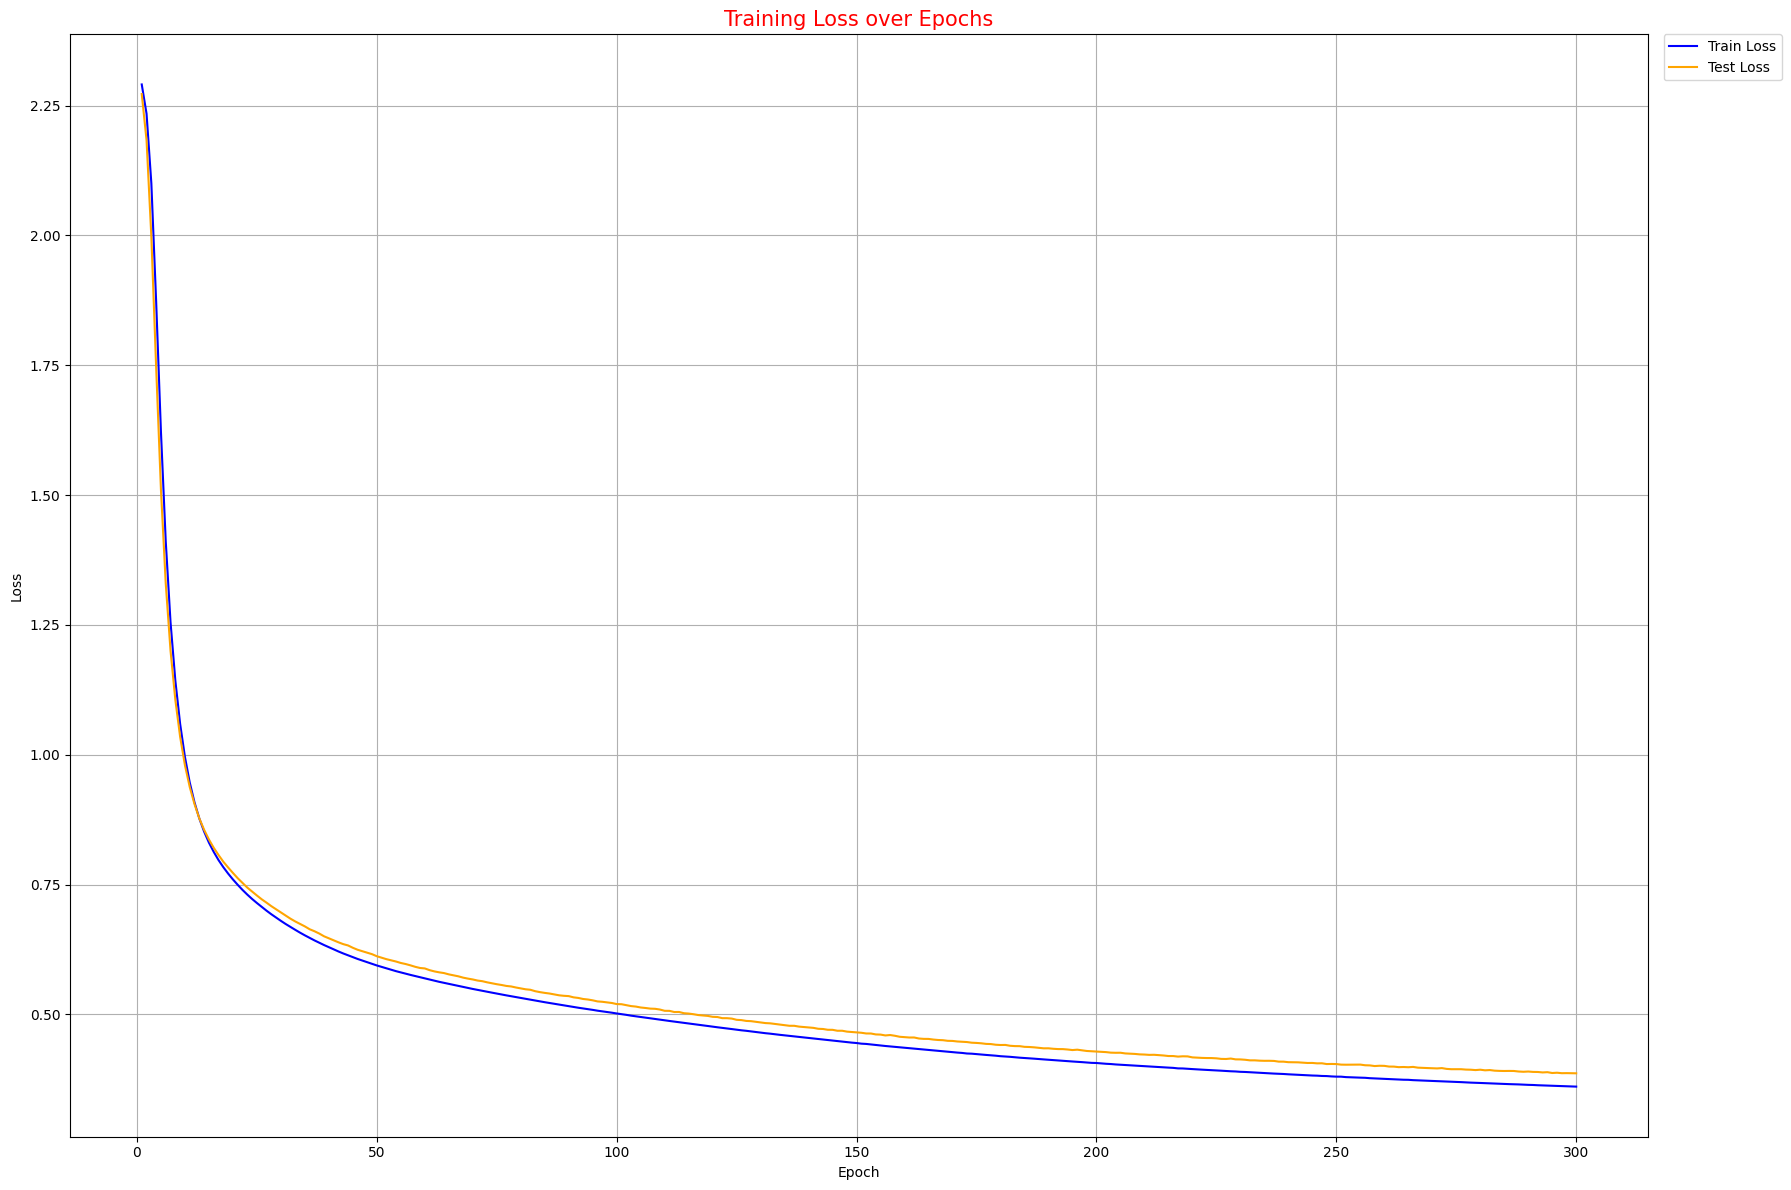 | Accuracy: 0.86 |
| AlexNet | 2012年の ILSVRC 2012 にて優勝し, 深層学習の火付け役になった | 約4時間 | 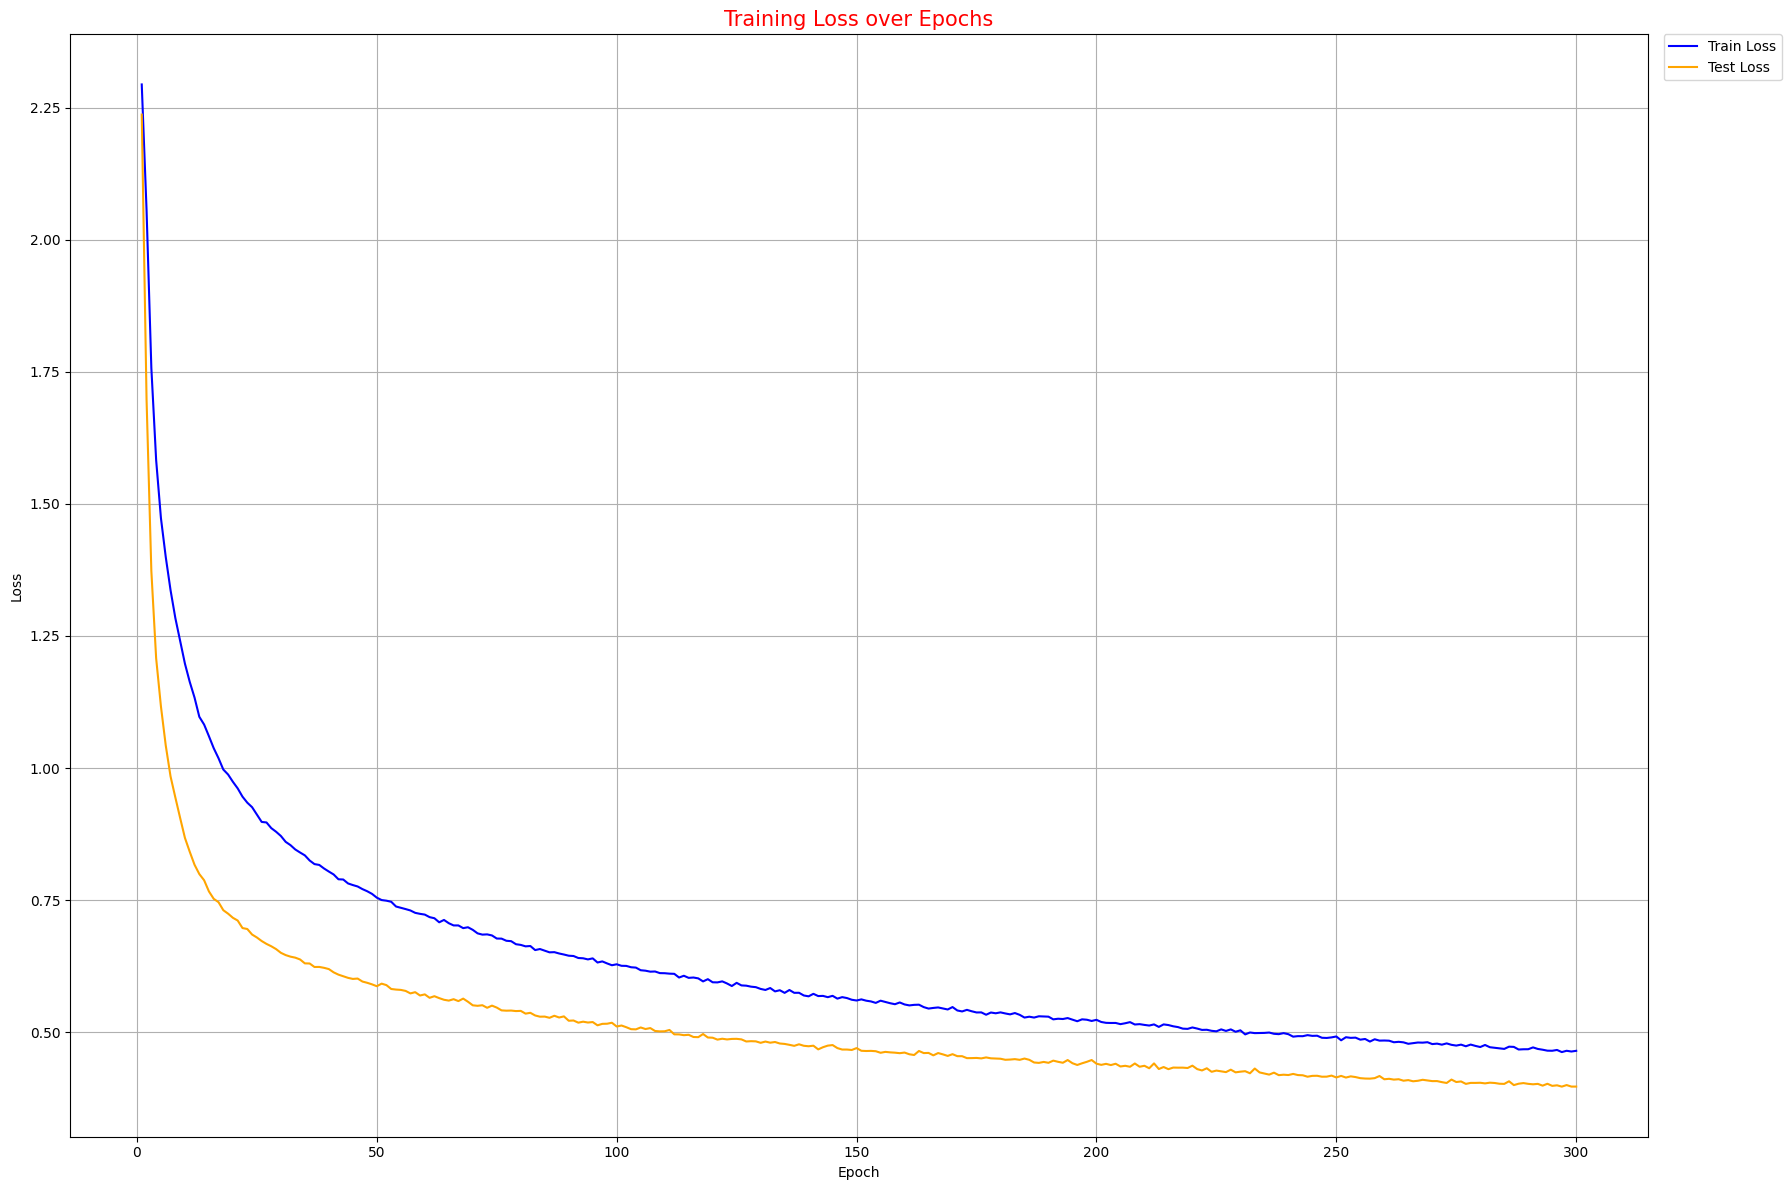 | Accuracy: 0.85 |
| VGG | 2014年に登場した, 学習コストは高いがシンプルで理解しやすいアーキテクチャであり, 後続研究に大きく貢献した | 約4時間30分 | 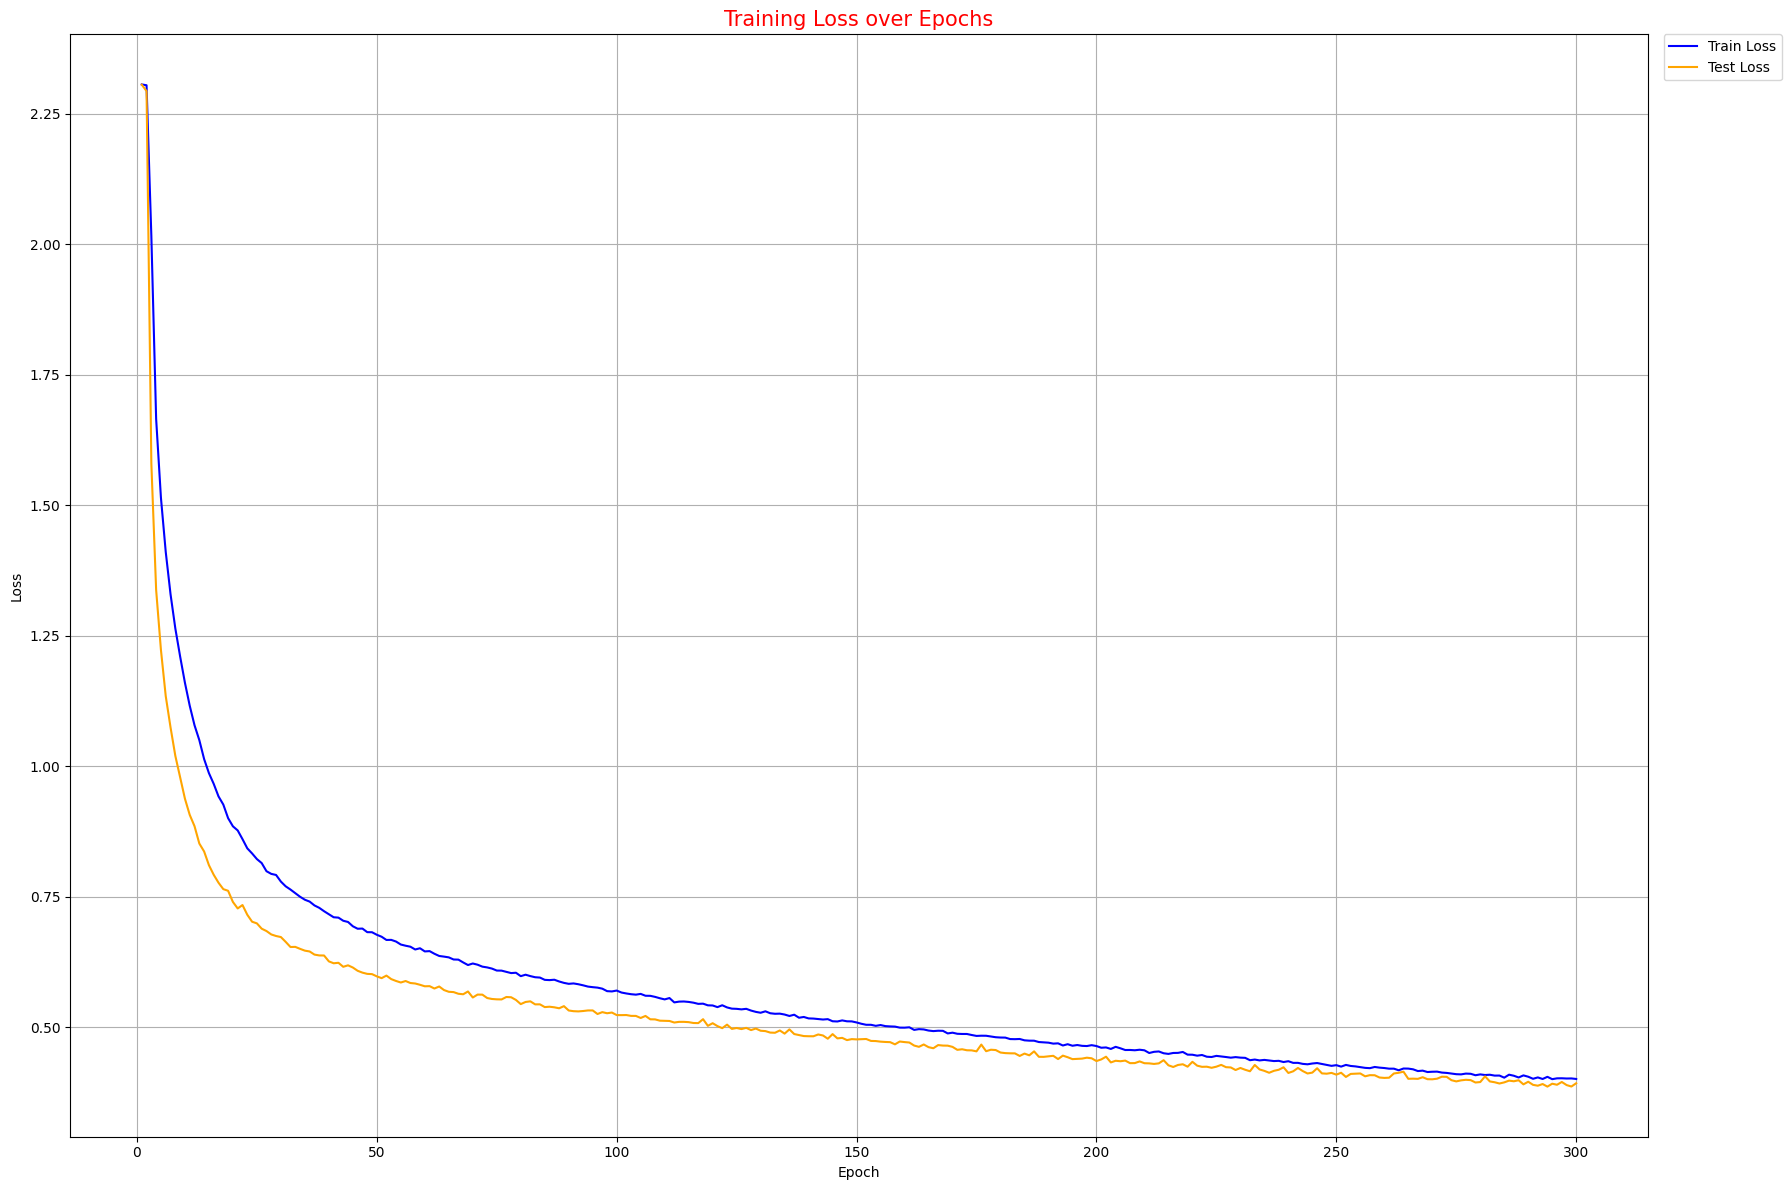 | Accuracy: 0.85 |
| ResNet | 2015年, 深すぎるニューラルネットワークで勾配消失が起こる問題を, 「残差接続」により安定化させられるようになった | 約11時間30分 | 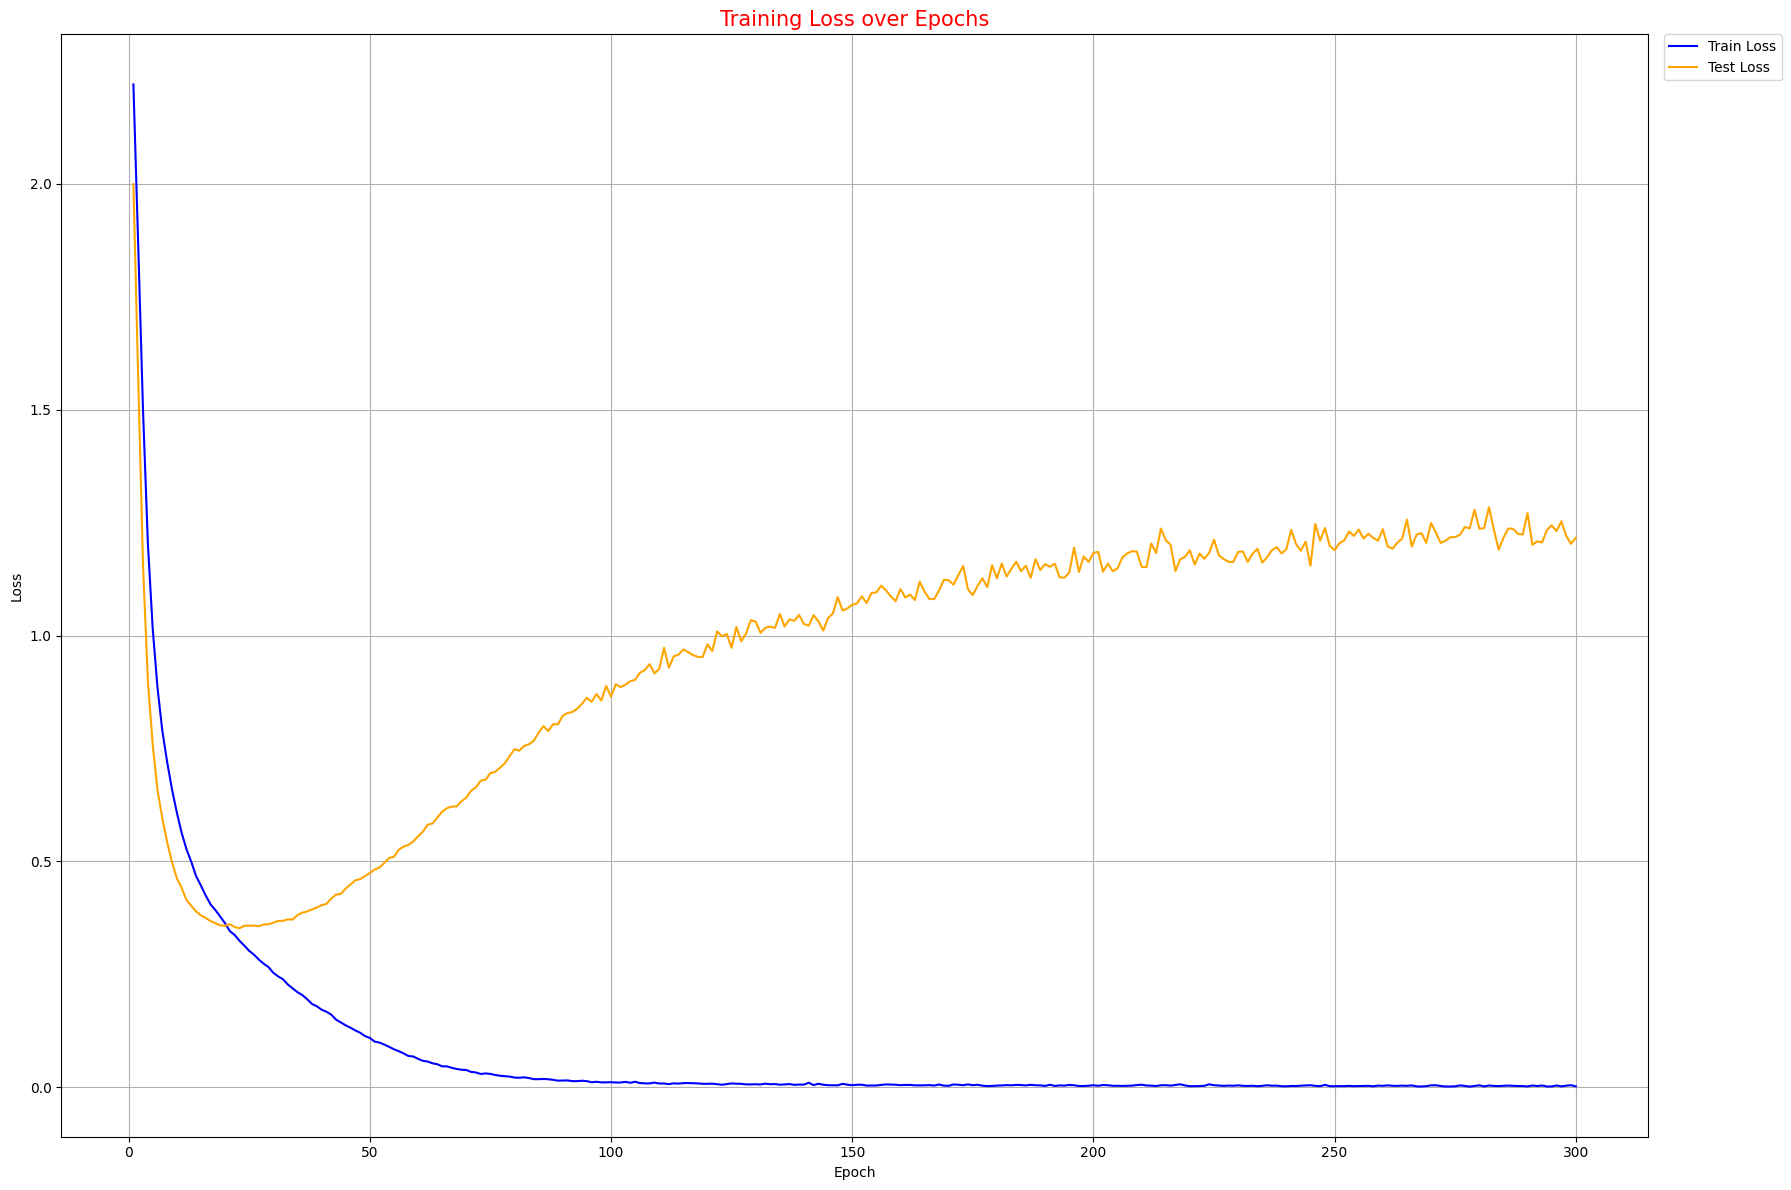 | Accuracy: 0.88 |